In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('data/MNIST/train.csv')
test_data = pd.read_csv('data/MNIST/test.csv')

In [3]:
# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (33600, 785)
Validation data shape: (8400, 785)


In the histogram below we can see a rougly even distribution of data across classes.

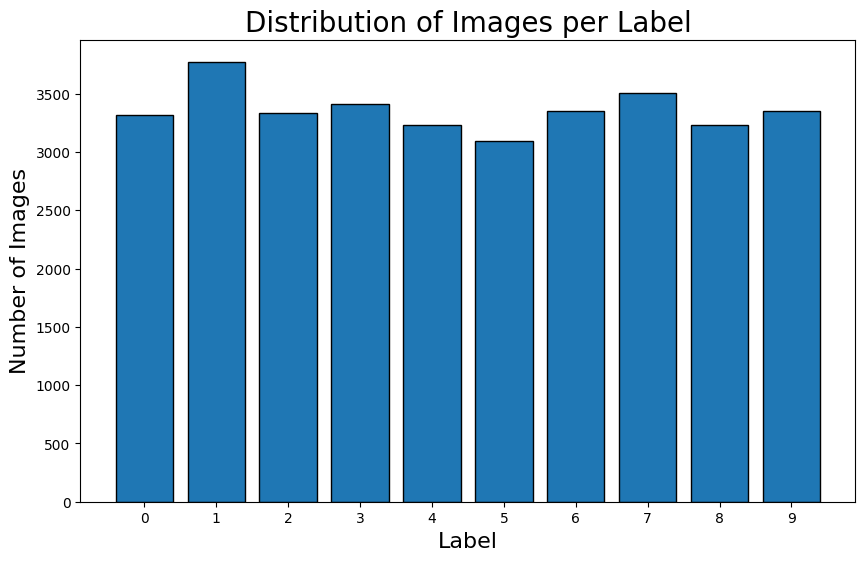

In [9]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
counts, bins, bars = plt.hist(
    train_data['label'], bins=10, edgecolor='black', rwidth=0.8
)
plt.title('Distribution of Images per Label', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Number of Images', fontsize=16)
plt.xticks(
    bins[:-1] + (bins[1] - bins[0]) / 2,
    labels=range(10),
)
plt.show()

In [15]:
print('There are', train_data.isna().sum().sum(), 'missing values in training data.')

There are 0 missing values in training data.
